# <center> Parcial 1
    
### <center> Manuel Francisco Martinez Motta
### <center> Manuela Isabella Nobile Russi

In [208]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim
from scipy.signal import argrelextrema
from scipy.interpolate import splrep,splint,splev,BSpline,sproot,splprep,bisplrep,bisplev

# Punto 3

In [209]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
    # Method
    def Evolution(self, i):
        self.SetPosition(i, self.r)
        self.SetVelocity(i, self.v)
    
    # Euler method
        self.r += self.dt * self.v + (1/2) * self.a * (self.dt)**2
        self.v += self.dt * self.a

    
    def CheckWallLimits(self,limits,e,dim):
        
        for i in range(dim):
            
            if self.r[i] + self.radius > limits[i]:
                self.v[i] = -e*self.v[i]
                self.r[i] = limits[i] - self.radius
                
            if self.r[i] - self.radius < - limits[i]:
                self.v[i] = -e*self.v[i]
                self.r[i] = -limits[i] + self.radius
    
    # Setters
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    # Getters  
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    
    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetR(self):
        return self.radius
    
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]]) # initial condition
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])
                            
               # print(self.RrVector)

In [210]:
dt = 0.01
tmax = 30
t = np.arange(0,tmax,dt)
print(len(t))

3000


In [227]:
x0 = np.array( [-15.,-10.] )
v0 = np.array( [2.,0.] )
a0 = np.array( [0.,-9.8] )
        
p = Particle(x0,v0,a0,t,1.,2.0,1)

In [228]:
Limits = np.array([40.,40.])

In [229]:
def RunSimulation(t):
    
    particle = p
    positions = []
    
    for it in tqdm(range(len(t))): # Evolucion temporal
            
        particle.CheckWallLimits(Limits,0.9,2)
        particle.Evolution(it)
        
    return particle

In [230]:
Particles = RunSimulation(t)

100%|███████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 35541.54it/s]


In [231]:
def ReduceTime(t,factor):
    
    Particles.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [232]:
redt = ReduceTime(t,40)

# Caida con restitución

Iteración los primeros 30 segundos con un paso temporal de $\Delta t = 0.01$.

<IPython.core.display.Javascript object>


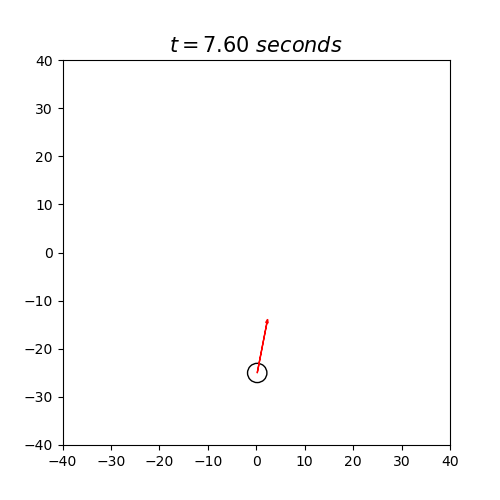

In [233]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)


def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])

def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    x = Particles.GetRPositionVector()[i,0]
    y = Particles.GetRPositionVector()[i,1]
        
    vx = Particles.GetRVelocityVector()[i,0]
    vy = Particles.GetRVelocityVector()[i,1]
        
    circle = plt.Circle( (x,y), Particles.GetR(), color='k', fill=False)
    plot = ax.add_patch(circle)
    plot = ax.arrow(x,y,vx,vy,color='r',head_width=0.5)
        
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

##### A) coeficiente de restitución

In [234]:
h0 = x0[1] #Altura inicial.

max_height_index = np.argmax(Particles.GetRPositionVector()[:, 1]) #Indice donde la partícula alcanza su altura máxima después de rebotar


h1 = Particles.GetRPositionVector()[max_height_index, 1] #Altura final.

e = np.sqrt(h1 / h0) #Coeficiente de restitución.

print("Altura inicial (h0):", h0)
print("Altura final (h1):", h1)
print("Coeficiente de restitución (e):", e)

Altura inicial (h0): -34.38459880120656
Altura final (h1): -10.0
Coeficiente de restitución (e): 0.5392846008889871


##### B) ¿Que tiempo tarda la pelota en dejar de rebotar?

In [235]:
x = np.linspace(0,40,100)

In [236]:
def Lagrange(x,xi,i,n):
    
    prod = 1.0
    
    for j in range(n+1): #tengo n+1 puntos 
        if i!=j:
            prod *= (x-xi[j])/(xi[i]-xi[j])
            
    return prod

In [237]:
def Poly(x,xi,fxi,n):
    
    summ = 0.
    
    for i in range(n+1):
        
        summ += fxi[i]*Lagrange(x,xi,i,n)
        
    return summ

In [ ]:
px2 = Poly(x,tt,a,2)

In [ ]:
tck1=splrep(tt,a,k=1)
t,c,k=tck1
L1=BSpline(t,c,k)

In [ ]:
fig, ax1 = plt.subplots()
plt.scatter(tt,a,color='r')
#plt.plot(x,px2)
plt.plot(x,L1(x),alpha=0.5,linewidth=2)
ax1 = plt.gca()
plt.show()
ax1.set_xlabel('t[s]')
ax1.set_ylabel('h[m]')
ax1.set_title('Estimación del tiempo rebote')

El tiempo que tarda la pelota en dejar de rebotar es aproximadamente $\approx 30 s$ 

# Punto 4

<!-- # Punto 4 -->

<IPython.core.display.Javascript object>


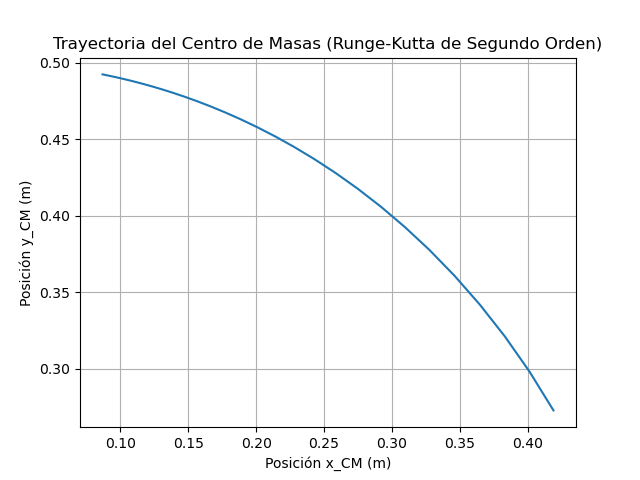

In [205]:
# Parámetros del sistema
L = 1.0  # Longitud de la barra en metros
m = 1.0  # Masa de la barra en kg
g = 9.81  # Aceleración debida a la gravedad en m/s^2

# Momento de inercia
I = (1/12) * m * L**2

# Ecuaciones diferenciales
def equations(t, y):
    theta, omega, y, vel = y
    
    N = m * g * np.cos(theta)
    y_dot = vel
    omega_dot = (N * (L/2) * np.sin(theta)) / I
    
    return [omega, omega_dot, y_dot, -g * np.cos(theta)]

# Método de Runge-Kutta de segundo orden
def runge_kutta_second_order(h, t, y, equations):
    k1 = h * np.array(equations(t, y))
    k2 = h * np.array(equations(t + h, y + k1))
    return y + (k1 + k2) / 2

# Condiciones iniciales
theta_0 = np.radians(10.0)  # Ángulo inicial en radianes
omega_0 = 0.0  # Velocidad angular inicial en rad/s
y_0 = L/2 * np.cos(theta_0)  # Posición inicial en metros
y_dot_0 = 0.0  # Velocidad inicial en m/s
initial_conditions = [theta_0, omega_0, y_0, y_dot_0]

# Tiempo de simulación
t_max = 10.0  # Tiempo máximo de simulación en segundos
delta_t = 0.01  # Paso de tiempo
t_span = np.arange(0, t_max, delta_t)

# Simulación utilizando el método de Runge-Kutta de segundo orden
solution = np.zeros((len(t_span), len(initial_conditions)))

# Condiciones iniciales
solution[0, :] = initial_conditions

# Integración numérica
for i in range(1, len(t_span)):
    solution[i, :] = runge_kutta_second_order(delta_t, t_span[i-1], solution[i-1, :], equations)
    
    # Detener la iteración cuando y <= 0
    if solution[i, 2] <= 0:
        solution = solution[:i+1, :]  # Recortar la solución hasta el punto de detención
        break

# Cálculo de las posiciones x_CM e y_CM del centro de masas
theta_values = solution[:, 0]
x_CM_values = L/2 * np.sin(theta_values)
y_CM_values = L/2 * np.cos(theta_values)

# Gráfica de y_CM vs x_CM
plt.plot(x_CM_values, y_CM_values)
plt.xlabel('Posición x_CM (m)')
plt.ylabel('Posición y_CM (m)')
plt.title('Trayectoria del Centro de Masas (Runge-Kutta de Segundo Orden)')
plt.grid(True)
plt.show()